In [33]:
import pandas as pd
from scipy.stats.stats import pearsonr
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [34]:
data2014 = pd.read_csv("Our_Dataset/2014dataset.csv")
data2015 = pd.read_csv("Our_Dataset/2015dataset.csv")
data2016 = pd.read_csv("Our_Dataset/2016dataset.csv")
data2017 = pd.read_csv("Our_Dataset/2017dataset.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,52,323,649,882,932,1092,1202) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,57,204,341,376,377,396,430,431,928,944,1006,1013,1151,1160,1169,1179,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,17,163,355,406,702,835,847,1083,1156,1183,1185,1200) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
# Create the labels.
# By index:
# label 2 is transfers
# label 3 is premiums
# label 4 is costs
# label 5 is member months
# label 6 is reinsurance (individual group only)

ind_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                  "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
                  "1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "STATE", "REINSURANCE PAYMENT AMOUNT (OR NOT ELIGIBLE)"] # no more reinsurance as of 2017
ind_labels_15 = [label.replace('15', '16') for label in ind_labels_14]
ind_labels_16 = [label.replace('15', '17') for label in ind_labels_14]
ind_labels_17 = [label.replace('15', '18') for label in ind_labels_14][:-1]

sg_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                 "HHS RISK ADJUSTMENT TRANSFERS AMOUNT (SMALL GROUP MARKET)",
                  "1.1Directpremiumwritten7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "2.16Totalincurredclaims7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15", "STATE"]
sg_labels_15 = [label.replace('15', '16') for label in sg_labels_14]
sg_labels_16 = [label.replace('15', '17') for label in sg_labels_14]
sg_labels_17 = [label.replace('15', '18') for label in sg_labels_14]

In [36]:
# Filter the data to include only the fields we want

ind_data_14 = data2014[ind_labels_14].dropna()
ind_data_15 = data2015[ind_labels_15].dropna()
ind_data_16 = data2016[ind_labels_16].dropna()
ind_data_17 = data2017[ind_labels_17].dropna()
sg_data_14 = data2014[sg_labels_14].dropna()
sg_data_15 = data2015[sg_labels_15].dropna()
sg_data_16 = data2016[sg_labels_16].dropna()
sg_data_17 = data2017[sg_labels_17].dropna()

In [37]:
# Drop companies with <2000 MM
ind_data_14 = ind_data_14.where(ind_data_14[ind_labels_14[5]] > 2000).dropna()
ind_data_15 = ind_data_15.where(ind_data_15[ind_labels_15[5]] > 2000).dropna()
ind_data_16 = ind_data_16.where(ind_data_16[ind_labels_16[5]] > 2000).dropna()
ind_data_17 = ind_data_17.where(ind_data_17[ind_labels_17[5]] > 2000).dropna()
sg_data_14 = sg_data_14.where(sg_data_14[sg_labels_14[5]] > 2000).dropna()
sg_data_15 = sg_data_15.where(sg_data_15[sg_labels_15[5]] > 2000).dropna()
sg_data_16 = sg_data_16.where(sg_data_16[sg_labels_16[5]] > 2000).dropna()
sg_data_17 = sg_data_17.where(sg_data_17[sg_labels_17[5]] > 2000).dropna()

In [39]:
# Calculate transfers, premiums, costs, and reinsurance (if individual group) per member month
def calculate_pmm(df, df_labels, group):
    df["MM"] = df[df_labels[5]]
    df["Transfers"] = df[df_labels[2]]
    df["Enrollees"] = df["MM"] / 12
    df["LogEnrollees"] = np.log(df["Enrollees"])
    df["LogTransfers"] = np.log(df["Transfers"]**2 + 1)
    df["TransfersPMM"] = df[df_labels[2]] / df[df_labels[5]]
    df["PremiumsPMM"] = abs(df[df_labels[3]] / df[df_labels[5]])
    df["CostsPMM"] = abs(df[df_labels[4]] / df[df_labels[5]])
    if group == "i":
        df["ReinsurancePMM"] = df[df_labels[7]] / df[df_labels[5]]
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"] + df["ReinsurancePMM"]
        #df["PremMinusCostsPlusReinsurancePMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["ReinsurancePMM"]
    elif group == "sg":
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["PremMinusCostsPMM"] = df["PremiumsPMM"] - df["CostsPMM"]
    df["PremMinusCostsPlusTransfersPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["SicknessPMM"] = df["CostsPMM"] - df["PremiumsPMM"]
    average_sickness = np.mean(df["SicknessPMM"])
    df["ExcessSicknessPMM"] = df["SicknessPMM"] - average_sickness
    return df

ind_data_14 = calculate_pmm(ind_data_14, ind_labels_14, "i")
ind_data_15 = calculate_pmm(ind_data_15, ind_labels_15, "i")
ind_data_16 = calculate_pmm(ind_data_16, ind_labels_16, "i")
ind_data_17 = calculate_pmm(ind_data_17, ind_labels_17, "sg")
sg_data_14 = calculate_pmm(sg_data_14, sg_labels_14, "sg")
sg_data_15 = calculate_pmm(sg_data_15, sg_labels_15, "sg")
sg_data_16 = calculate_pmm(sg_data_16, sg_labels_16, "sg")
sg_data_17 = calculate_pmm(sg_data_17, sg_labels_17, "sg")

In [40]:
# Combine the dataframes by left merging

ind_data = ind_data_14.merge(ind_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(ind_data_16, on='HIOS ID', how='outer').merge(ind_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [41]:
# Do the same thing for small group

sg_data = sg_data_14.merge(sg_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(sg_data_16, on='HIOS ID', how='outer').merge(sg_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [42]:
sg_data.shape

(611, 77)

In [66]:
def plot(df, label):
    no_nulls = df[['LogEnrollees', 'LogTransfers']].dropna()
    X = no_nulls[['LogEnrollees']]
    y = no_nulls['LogTransfers']
    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(df["LogEnrollees"], df["LogTransfers"])
    x = np.linspace(min(df["LogEnrollees"]), max(df["LogEnrollees"]), 1000)
    equation = "Log T = %f + %f * Log Enrollees" % (est.params[0], est.params[1])
    plt.plot(x, est.params[0] + est.params[1] * x, label=equation)
    plt.title(label)
    plt.xlabel("Log # Enrollees")
    plt.ylabel("Log Transfers^2 + 1")
    plt.legend()
    plt.show()
    print(label)
    print(equation)
    
def state(df, state):
    return df.where(df["STATE"] == state).where(df["LogTransfers"] > 2).dropna()

def remove_outliers(df):
    return df.where(df["LogTransfers"] > 2).dropna()

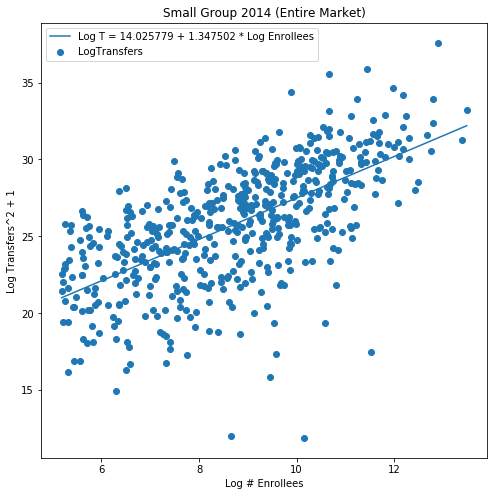

Small Group 2014 (Entire Market)
Log T = 14.025779 + 1.347502 * Log Enrollees


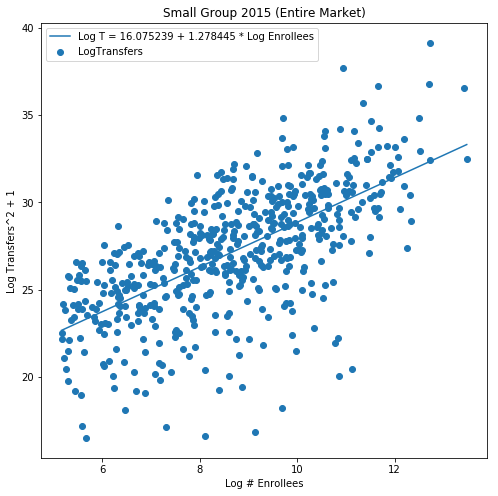

Small Group 2015 (Entire Market)
Log T = 16.075239 + 1.278445 * Log Enrollees


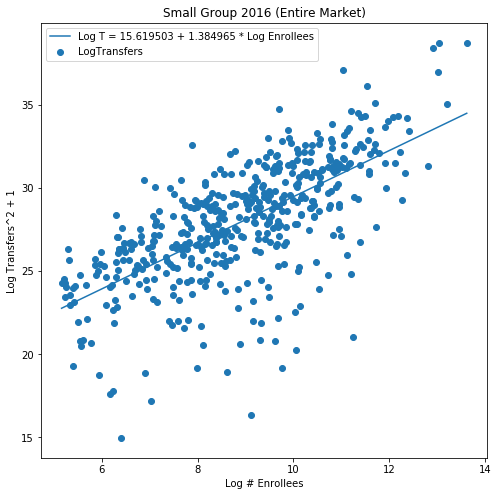

Small Group 2016 (Entire Market)
Log T = 15.619503 + 1.384965 * Log Enrollees


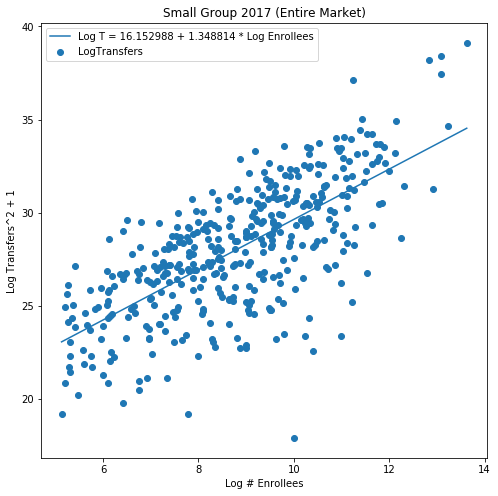

Small Group 2017 (Entire Market)
Log T = 16.152988 + 1.348814 * Log Enrollees


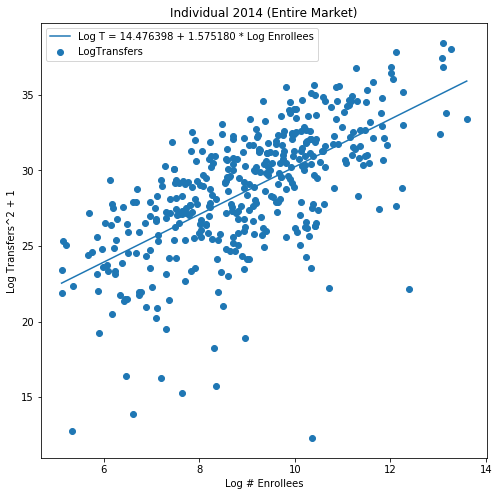

Individual 2014 (Entire Market)
Log T = 14.476398 + 1.575180 * Log Enrollees


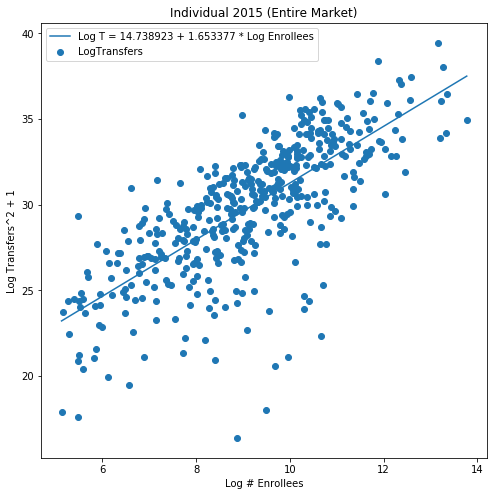

Individual 2015 (Entire Market)
Log T = 14.738923 + 1.653377 * Log Enrollees


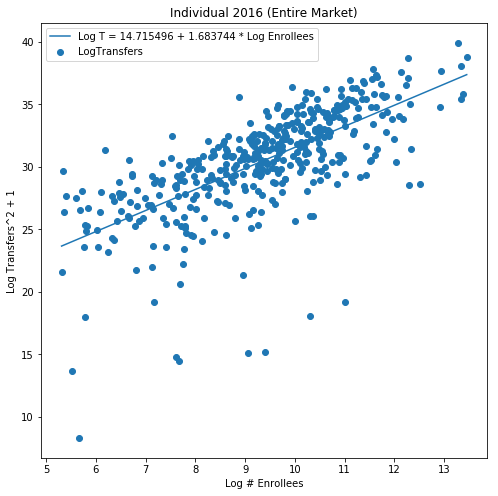

Individual 2016 (Entire Market)
Log T = 14.715496 + 1.683744 * Log Enrollees


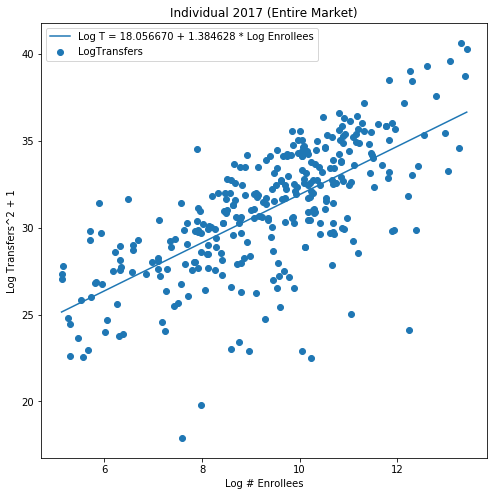

Individual 2017 (Entire Market)
Log T = 18.056670 + 1.384628 * Log Enrollees


In [67]:
plot(remove_outliers(sg_data_14), "Small Group 2014 (Entire Market)")
plot(remove_outliers(sg_data_15), "Small Group 2015 (Entire Market)")
plot(remove_outliers(sg_data_16), "Small Group 2016 (Entire Market)")
plot(remove_outliers(sg_data_17), "Small Group 2017 (Entire Market)")

plot(remove_outliers(ind_data_14), "Individual 2014 (Entire Market)")
plot(remove_outliers(ind_data_15), "Individual 2015 (Entire Market)")
plot(remove_outliers(ind_data_16), "Individual 2016 (Entire Market)")
plot(remove_outliers(ind_data_17), "Individual 2017 (Entire Market)")

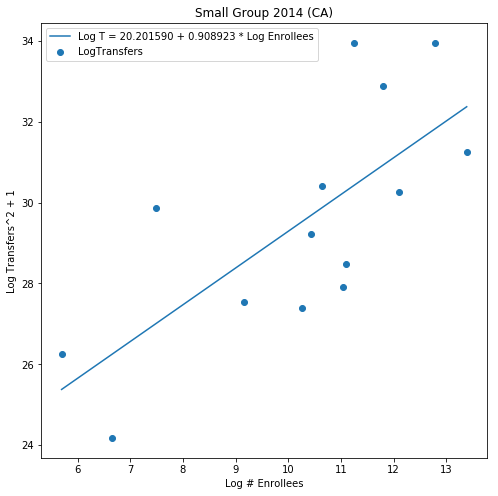

Small Group 2014 (CA)
Log T = 20.201590 + 0.908923 * Log Enrollees


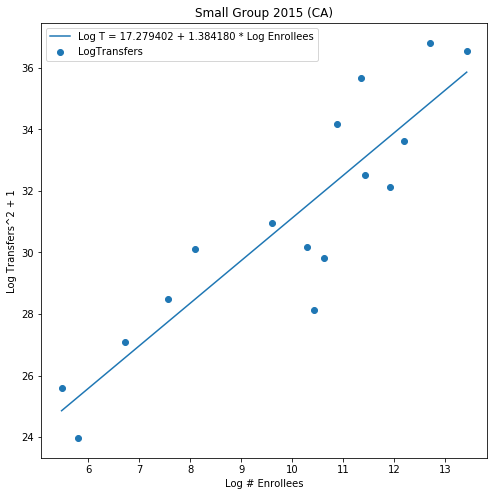

Small Group 2015 (CA)
Log T = 17.279402 + 1.384180 * Log Enrollees


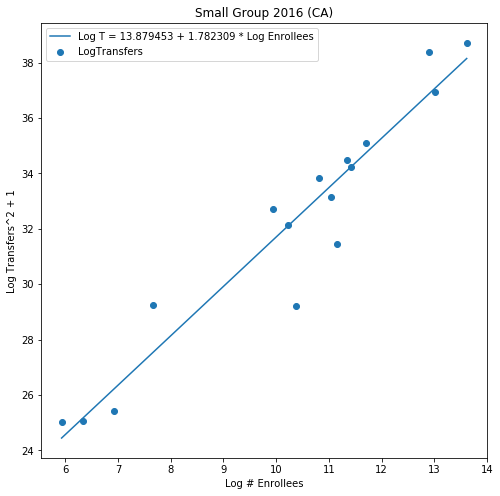

Small Group 2016 (CA)
Log T = 13.879453 + 1.782309 * Log Enrollees


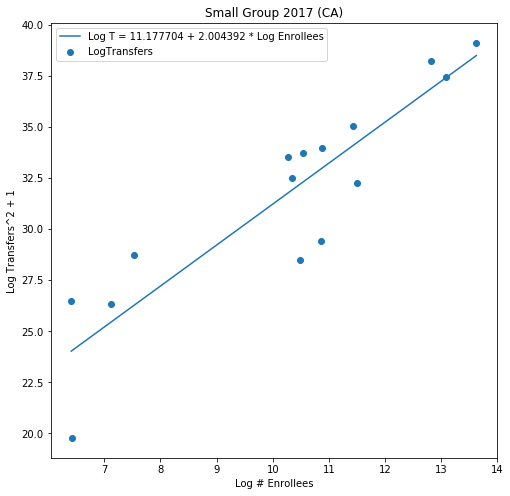

Small Group 2017 (CA)
Log T = 11.177704 + 2.004392 * Log Enrollees


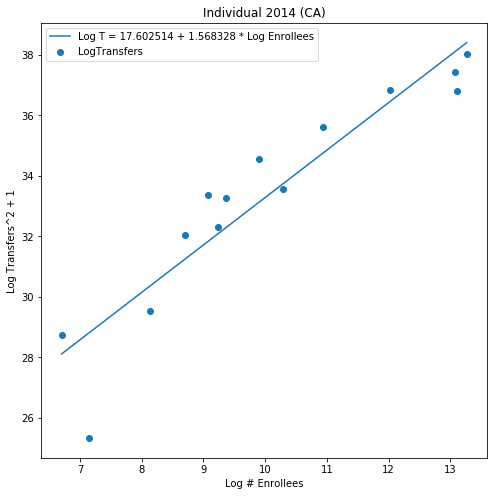

Individual 2014 (CA)
Log T = 17.602514 + 1.568328 * Log Enrollees


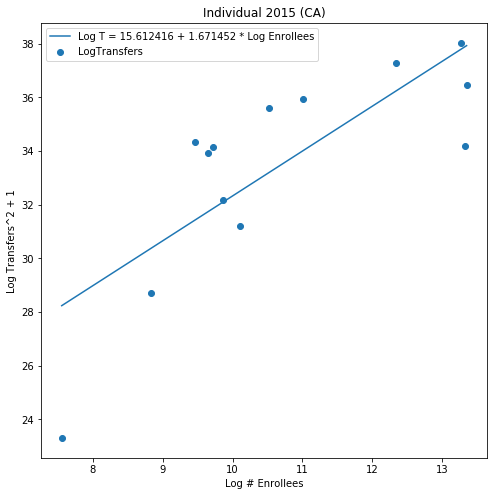

Individual 2015 (CA)
Log T = 15.612416 + 1.671452 * Log Enrollees


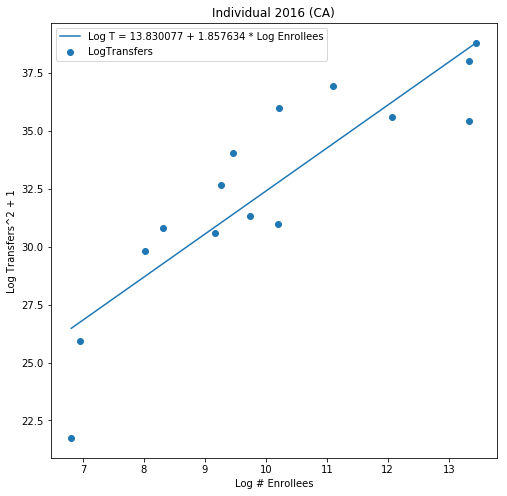

Individual 2016 (CA)
Log T = 13.830077 + 1.857634 * Log Enrollees


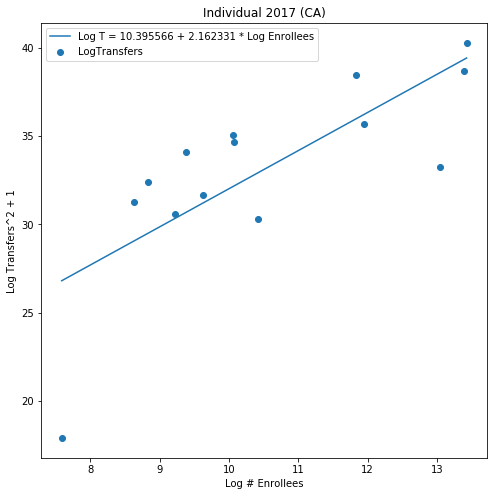

Individual 2017 (CA)
Log T = 10.395566 + 2.162331 * Log Enrollees


In [69]:
plot(state(sg_data_14, "CA"), "Small Group 2014 (CA)")
plot(state(sg_data_15, "CA"), "Small Group 2015 (CA)")
plot(state(sg_data_16, "CA"), "Small Group 2016 (CA)")
plot(state(sg_data_17, "CA"), "Small Group 2017 (CA)")

plot(state(ind_data_14, "CA"), "Individual 2014 (CA)")
plot(state(ind_data_15, "CA"), "Individual 2015 (CA)")
plot(state(ind_data_16, "CA"), "Individual 2016 (CA)")
plot(state(ind_data_17, "CA"), "Individual 2017 (CA)")

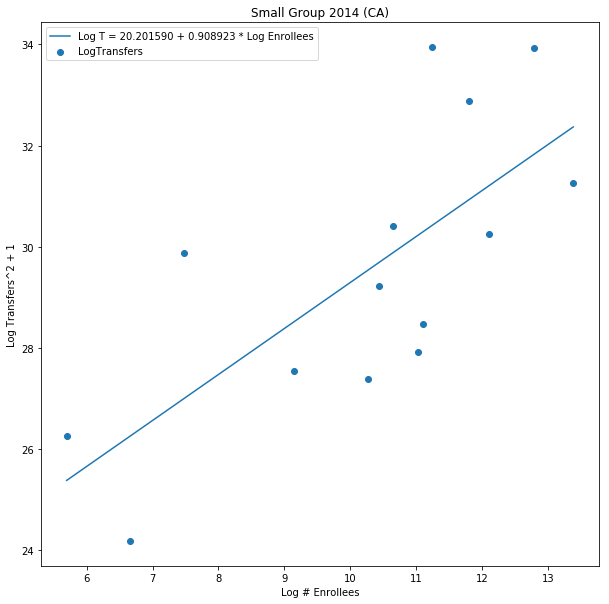

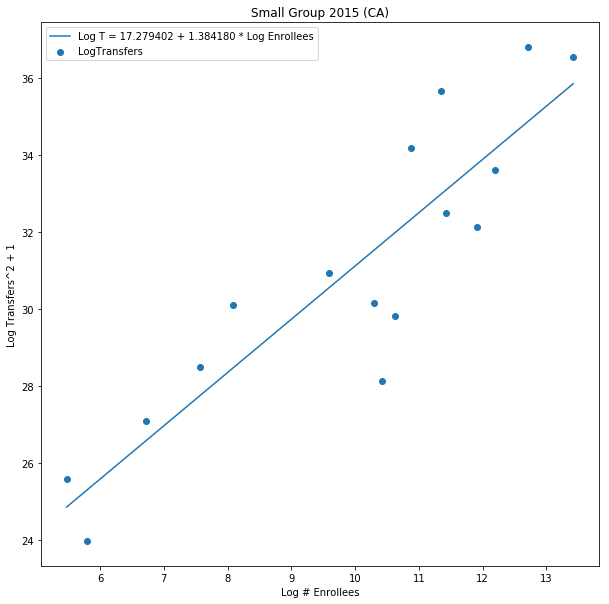

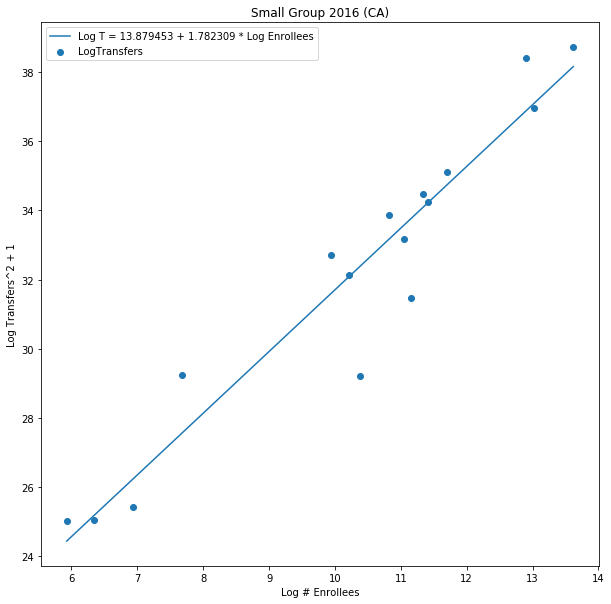

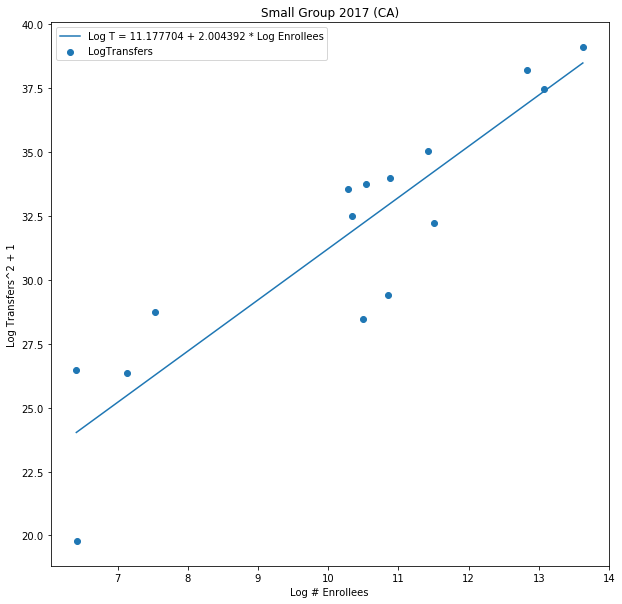

In [58]:
plot(state(sg_data_14, "CA"), "Small Group 2014 (CA)")
plot(state(sg_data_15, "CA"), "Small Group 2015 (CA)")
plot(state(sg_data_16, "CA"), "Small Group 2016 (CA)")
plot(state(sg_data_17, "CA"), "Small Group 2017 (CA)")

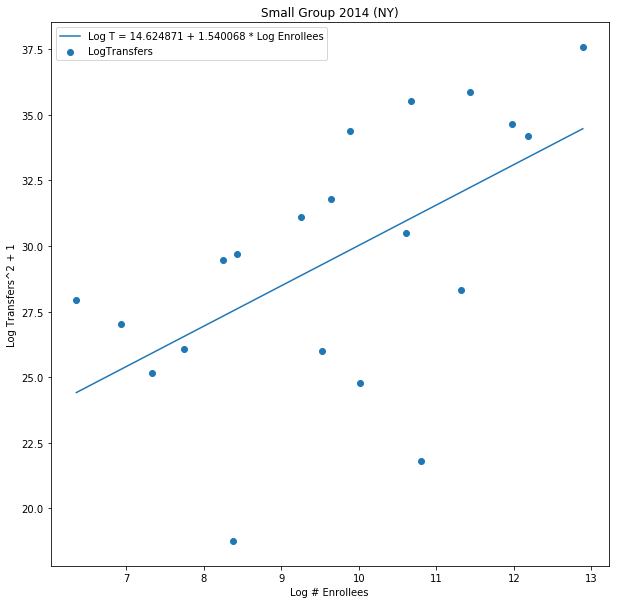

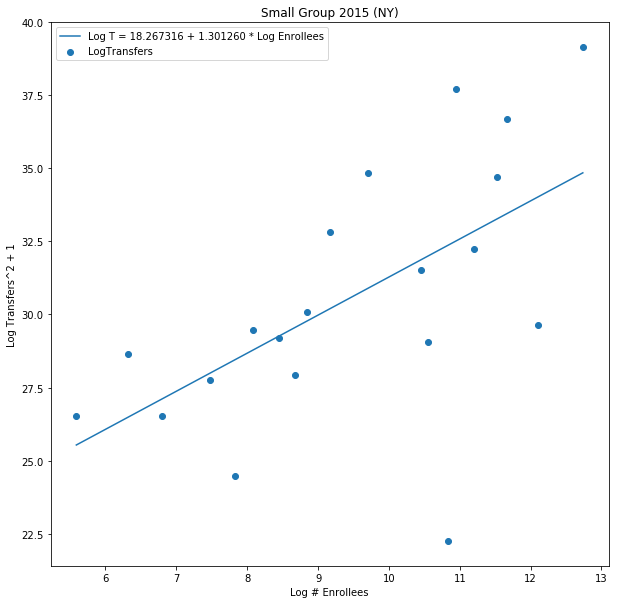

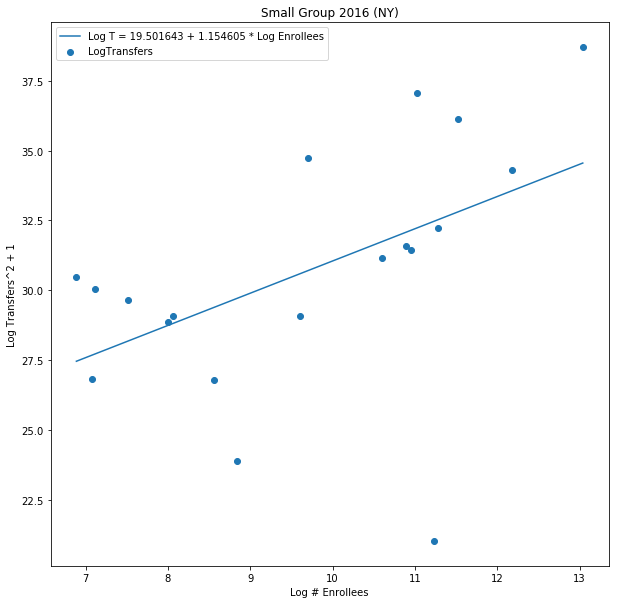

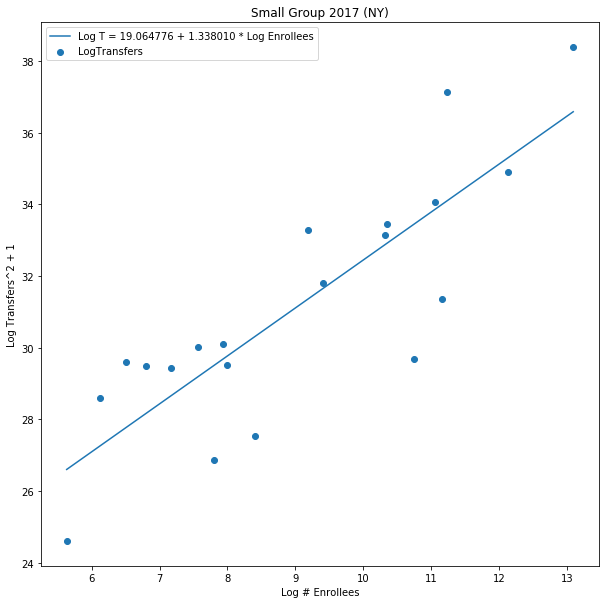

In [59]:
plot(state(sg_data_14, "NY"), "Small Group 2014 (NY)")
plot(state(sg_data_15, "NY"), "Small Group 2015 (NY)")
plot(state(sg_data_16, "NY"), "Small Group 2016 (NY)")
plot(state(sg_data_17, "NY"), "Small Group 2017 (NY)")